# Kombinált ciklusú erőmű teljesítményének előrejelzése gépi tanulással (feltáró adatelemzés és modellépítés)

## Bevezetés

A vizsgálat célja, hogy különböző regressziós modellek segítségével előrejelezzem egy gázturbinás erőmű elektromos teljesítményét. A feladat során három fájl állt rendelkezésre:
egy tanulmány (Article.pdf), amelyben már történt kísérlet hasonló predikcióra, egy tanító adatfájl (Train.xlsx), amelyen a modelleket ki kellett fejleszteni és optimalizálni, valamint egy külön tesztfájl (Test.xlsx), amely kizárólag a modell kiértékelésére szolgált, ismeretlen adatokkal.  

A tanító és teszt adathalmaz az erőmű működésének jellemzőit tartalmazza. A bemeneti (input) változók a következők:

AT – Környezeti hőmérséklet (Ambient Temperature)
V – Vákuum
AP – Atmoszférikus nyomás
RH – Relatív páratartalom

A célváltozó (target) az elektromos teljesítmény (PE, Power Output), amelyet a fenti jellemzők alapján szeretnék megbecsülni. A cél az volt, hogy megtaláljam a legpontosabb modellt, amely nemcsak a tanuló adatokon teljesít jól, hanem általánosítani is képes a valódi, ismeretlen adatokra.

A munkám során figyelembe vettem a tanulmányban (Article.pdf) bemutatott megoldásokat is, és ezekből kiindulva igyekeztem egy még pontosabb, robusztusabb modell irányába konvergálni.

## EDA

In [1]:
import pandas as pd

df_train = pd.read_excel('Train.xlsx')
df_test = pd.read_excel('Test.xlsx')

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', 100)  # vagy kisebb

# a végén majd inkább ezzel mert jobban tiszteli a vscode:
# from IPython.display import display

# with pd.option_context('display.max_colwidth', None):
#     display(results_df)

környezeti hőmérséklet (AT)  
az atmoszférikus nyomás (AP)  
a relatív páratartalom (RH)  
vákuum (V)  
  
elektromos teljesítmény (PE)  

In [3]:
df_train.head(5)

,AT,V,AP,RH,PE
0,10.54,34.03,1018.71,74.00,478.77
1,7.08,39.99,1010.55,91.44,482.83
2,14.49,41.16,1000.50,82.17,465.24
3,10.73,25.36,1009.35,100.15,469.43
4,22.88,63.91,1009.63,87.82,442.50


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8568 entries, 0 to 8567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      8568 non-null   float64
 1   V       8568 non-null   float64
 2   AP      8568 non-null   float64
 3   RH      8568 non-null   float64
 4   PE      8568 non-null   float64
dtypes: float64(5)
memory usage: 334.8 KB


In [5]:
df_train.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

### Várható érték és szórás

In [6]:
df_train_mean = df_train.mean()
df_train_std = df_train.std()

df_stats = pd.DataFrame({
    'várható érték':df_train_mean,
    'szórás':df_train_std
})

df_stats

,várható érték,szórás
AT,19.588562,7.463503
V,54.243393,12.724457
AP,1013.276923,5.939926
RH,73.403318,14.529301
PE,454.503761,17.117243


### Pairplot

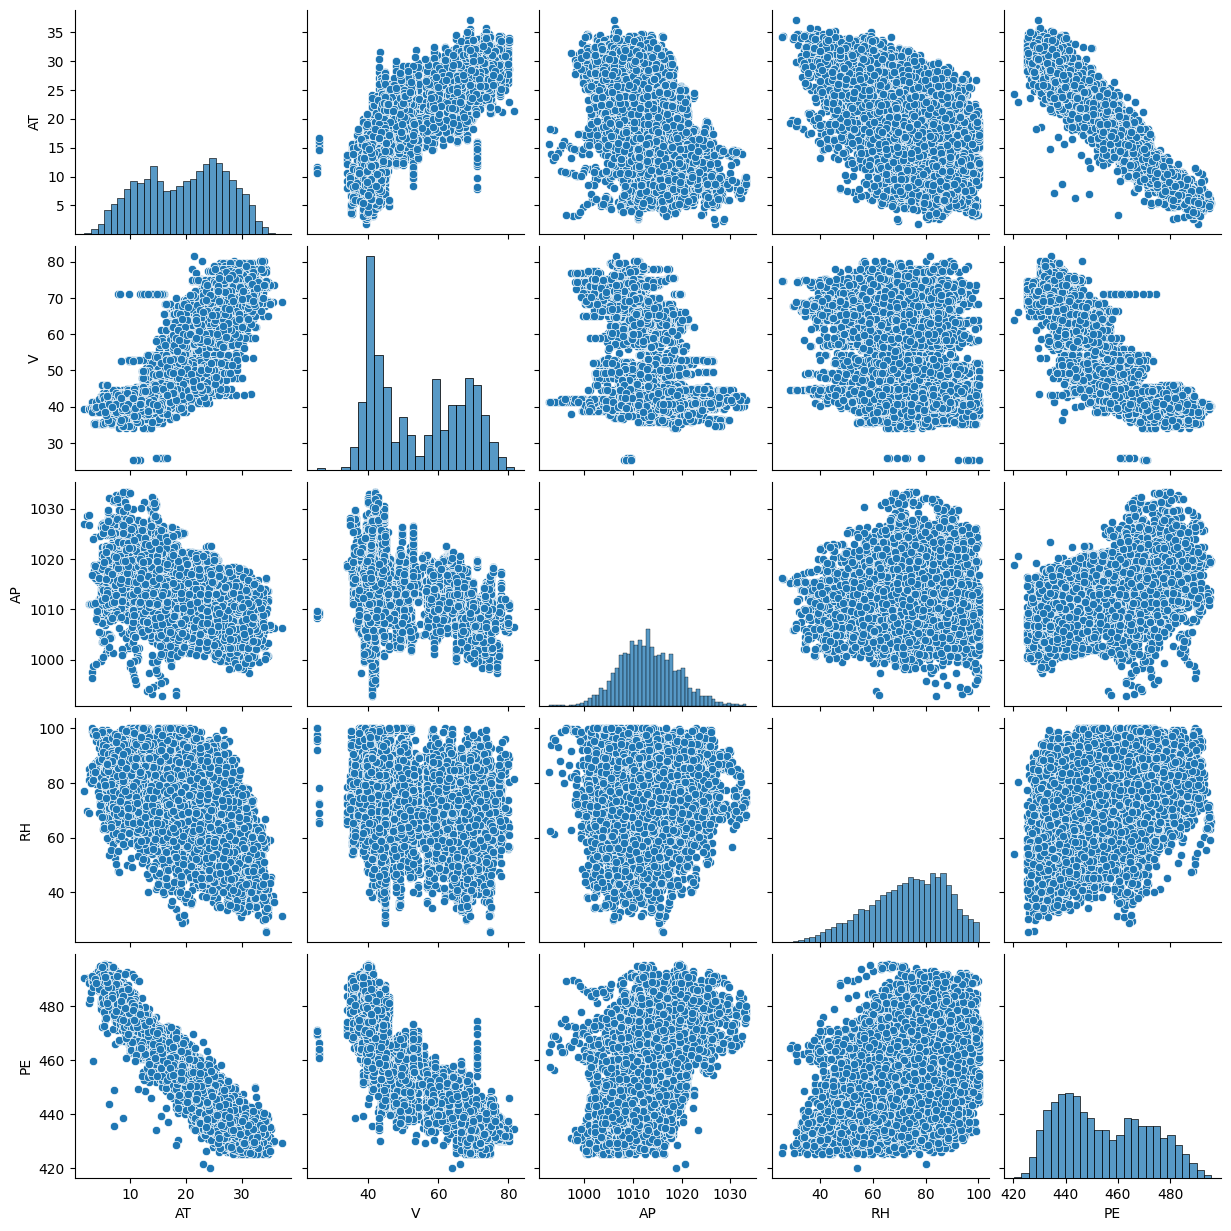

In [7]:
import seaborn as sns

sns.pairplot(df_train)

Megfigyelhető összefüggések a pairplot alapján:

Környezeti hőmérséklet (AT) – Elektromos teljesítmény (PE):
A pairplot alapján az adott két változó között erős negatív lineáris korreláció figyelhető meg, vagyis az egyik változó növekedésével a másik jellemzően csökken. Az adatpontok egy szűk, lefelé tartó sáv mentén helyezkednek el, ami arra utal, hogy a kapcsolat viszonylag szoros és jól leírható egy lineáris regresszióval is. Ahogy a környezeti hőmérséklet (AT) csökken, az elektromos teljesítmény (PE) nő.

Vákuum (V) – Elektromos teljesítmény (PE):
Hasonló mintázat figyelhető meg ebben az esetben is: negatív lineáris kapcsolat jellemzi a két változót. A vákuum (V) csökkenésével az elektromos teljesítmény (PE) emelkedik, ami szintén szoros, közel lineáris összefüggésre utal.

Vákuum (V) – Környezeti hőmérséklet (AT):
Ebben az esetben pozitív lineáris korreláció tapasztalható, azaz a vákuum (V) növekedésével a környezeti hőmérséklet (AT) értéke is emelkedik. Az adatpontok viszonylag szoros, felfelé tartó sávban helyezkednek el.

Eloszlások:

Atmoszférikus nyomás (AP):
Az eloszlása közel normális eloszlást mutat, szimmetrikus haranggörbére emlékeztető formával, jelentősebb torzulás nélkül.

Relatív páratartalom (RH):
A relatív páratartalom eloszlása enyhén balra ferde (negatív ferdeségű), vagyis az átlagértéknél alacsonyabb értékek gyakrabban fordulnak elő, ami torzítja az eloszlást az alacsonyabb értékek irányába. Meg lehet majd vizsgálni, hogy lehet-e a ferdeségen javítani transzformációval.

### Outlier vizsgálat (IQR)

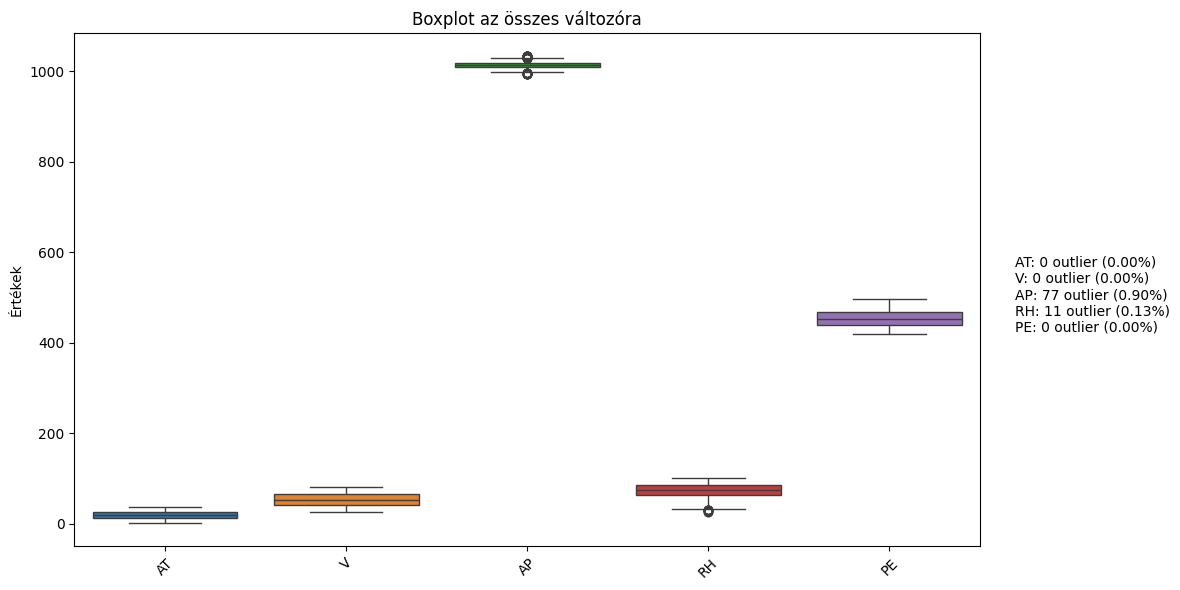

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

outlier_stats = {}

for col in df_train.columns:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    percentage = (outlier_count / len(df_train)) * 100

    outlier_stats[col] = {
        'outlier_count': outlier_count,
        'percentage': percentage
    }

# Boxplot rajzolás
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train)
plt.title('Boxplot az összes változóra')
plt.ylabel('Értékek')
plt.xticks(rotation=45)

# Outlier infó szöveg generálása
legend_text = "\n".join([
    f"{col}: {stats['outlier_count']} outlier ({stats['percentage']:.2f}%)"
    for col, stats in outlier_stats.items()
])

# Szöveg hozzáadása a plothoz
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center', ha='left')

plt.tight_layout()
plt.show()


Az outlierek kezelésére több lehetőség is van. Én először IQR-alapon vizsgáltam őket: megnéztem az alsó (Q1) és felső (Q3) kvartilist, majd minden olyan értéket outliernek vettem, ami Q1 – 1.5×IQR alatt vagy Q3 + 1.5×IQR felett volt. Ez egy bevált módszer az extrém értékek kiszűrésére.

A boxplot segítségével könnyen látszott, hogy mely változóknál van több kiugró érték, és milyen arányban.

Ha nem akarjuk ezeket az adatokat kidobni, van lehetőség a hatásuk csökkentésére, például StandardScaler használatával, ami standardizálja az adatokat. Ezen kívül létezik a Winsorizálás is, ahol egyszerűen levágjuk a túl extrém értékeket egy adott szintnél.

Mivel nálam az outlierek aránya kicsi volt, a legegyszerűbb megoldásnak az tűnt, ha ezeket egyszerűen eltávolítottam. Ez segít, hogy a modell ne torzuljon miattuk.

In [9]:
df_train_with_outlier = df_train.shape[0]

In [10]:
def remove_outliers_iqr(df):
    outlier_indices = set()

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Az adott oszlopban outlier sorok indexei
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.update(outliers)

    # Az összes érintett sor egyszerre eltávolítva
    return df.drop(index=outlier_indices)
df_train = remove_outliers_iqr(df_train)

In [11]:
df_train_with_outlier = df_train.shape[0]
df_train = remove_outliers_iqr(df_train)
f_shape_without_outlier = df_train.shape[0]

print(f'{df_train_with_outlier - f_shape_without_outlier} were removed as an outlier.')

6 were removed as an outlier.


### Eloszlás ferdeség vizsgálata

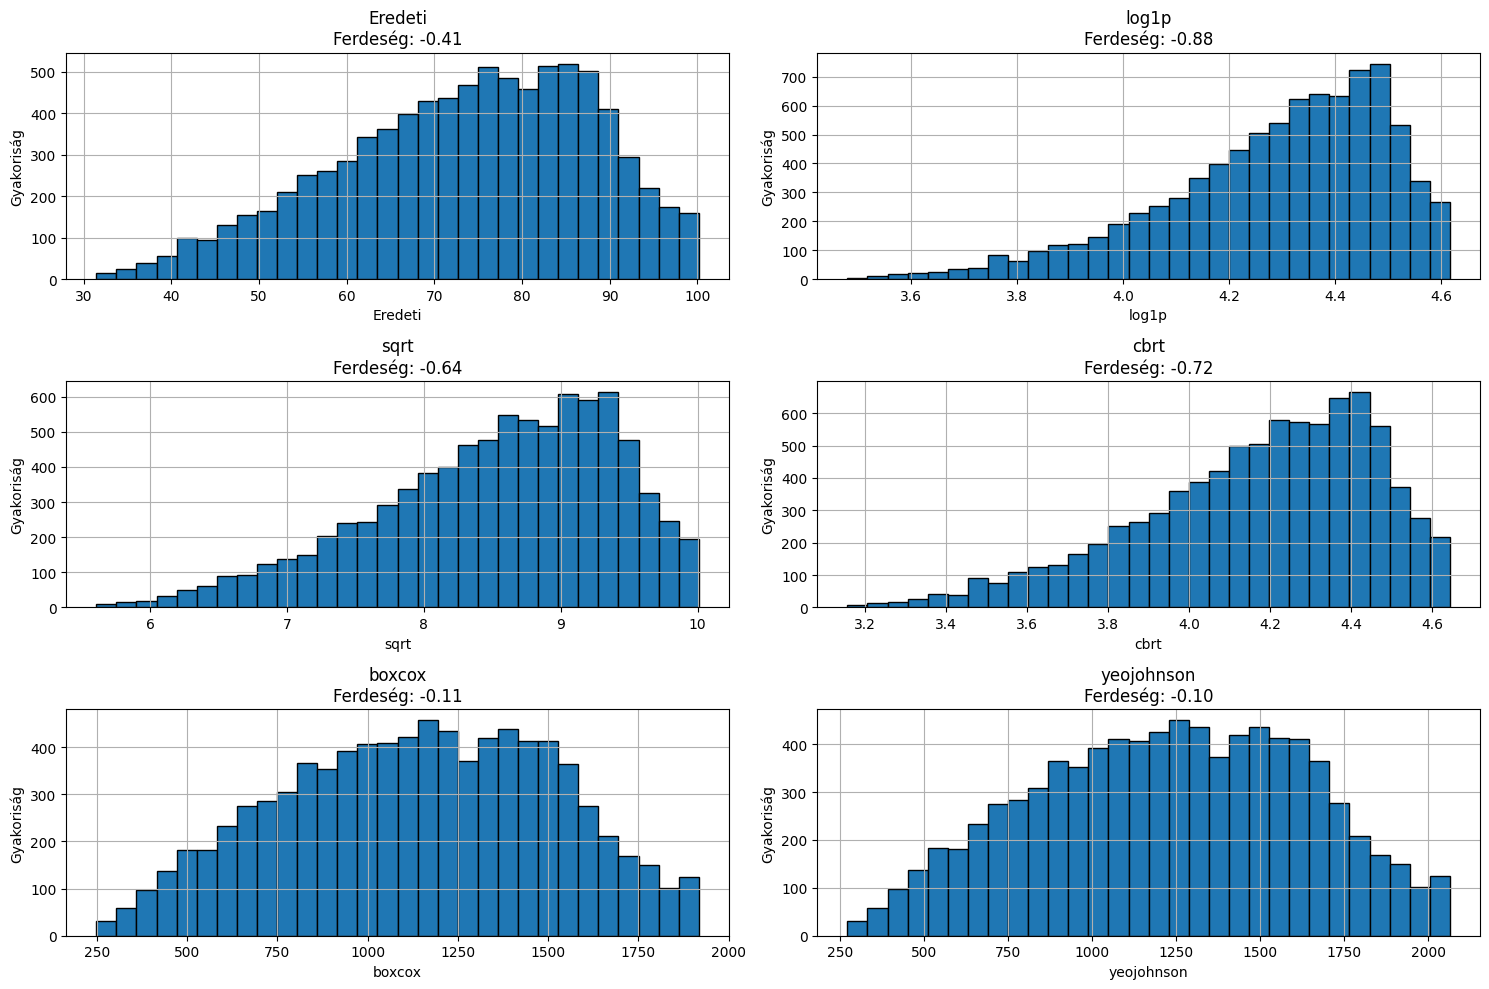

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import boxcox, yeojohnson

# Kiinduló oszlop
rh = df_train['RH']

# Transzformációk (index megőrzésével!)
transforms = {
    'Eredeti': rh,
    'log1p': pd.Series(np.log1p(rh), index=rh.index),
    'sqrt': pd.Series(np.sqrt(rh), index=rh.index),
    'cbrt': pd.Series(np.cbrt(rh), index=rh.index),
    'boxcox': pd.Series(boxcox(rh + 1e-3)[0], index=rh.index),  # kis eltolás, hogy ne legyen 0
    'yeojohnson': pd.Series(yeojohnson(rh)[0], index=rh.index)
}

# Ferdeségek számítása
skews = {name: series.skew() for name, series in transforms.items()}

# Ábrázolás
plt.figure(figsize=(15, 10))
for i, (name, series) in enumerate(transforms.items(), 1):
    plt.subplot(3, 2, i)
    series.hist(bins=30, edgecolor='black')
    plt.title(f'{name}\nFerdeség: {skews[name]:.2f}')
    plt.xlabel(name)
    plt.ylabel('Gyakoriság')
plt.tight_layout()
plt.show()


A relatív páratartalom (RH) eloszlásának vizsgálata során csökkenteni kell az eloszlás ferdeségét, mivel torzíthatja a regressziós modell pontosságát. Ennek érdekében különböző matematikai transzformációkat alkalmaztam az RH változóra, és összehasonlítottam azok hatását a változó ferdeségére.

Az eredeti eloszlás enyhén balra ferde képet mutatott (ferdeség: –0.43), ami arra utal, hogy az átlagtól kisebb értékek gyakrabban fordulnak elő. A ferdeség csökkentésére több transzformációt is kipróbáltam: logaritmikus (log1p), négyzetgyök (sqrt), köbgyök (cbrt), Box-Cox, valamint Yeo-Johnson transzformációkat.

Az eredmények alapján a Box-Cox (ferdeség: –0.11) és Yeo-Johnson (ferdeség: –0.10) transzformációk bizonyultak a leghatékonyabbnak a ferdeség közelítésében a nullához, vagyis ezek tudták a legjobban szimmetrikusabbá tenni az eloszlást. Ez különösen előnyös lehet lineáris modellek esetén, ahol a prediktorváltozók normalitása javíthatja a modell általánosítási képességét.

Az eredmények alapján a Yeo-Johnson transzformáció alkalmazása tűnik a legideálisabbnak.

In [13]:
df_train['RH'] = pd.Series(yeojohnson(df_train['RH'])[0], index=df_train.index)

### Korrelációs mátrix

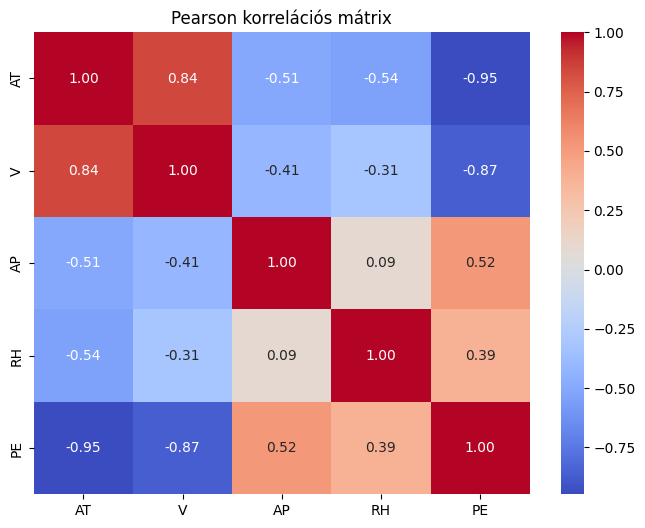

In [14]:
corr_matrix = df_train.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson korrelációs mátrix')
plt.show()

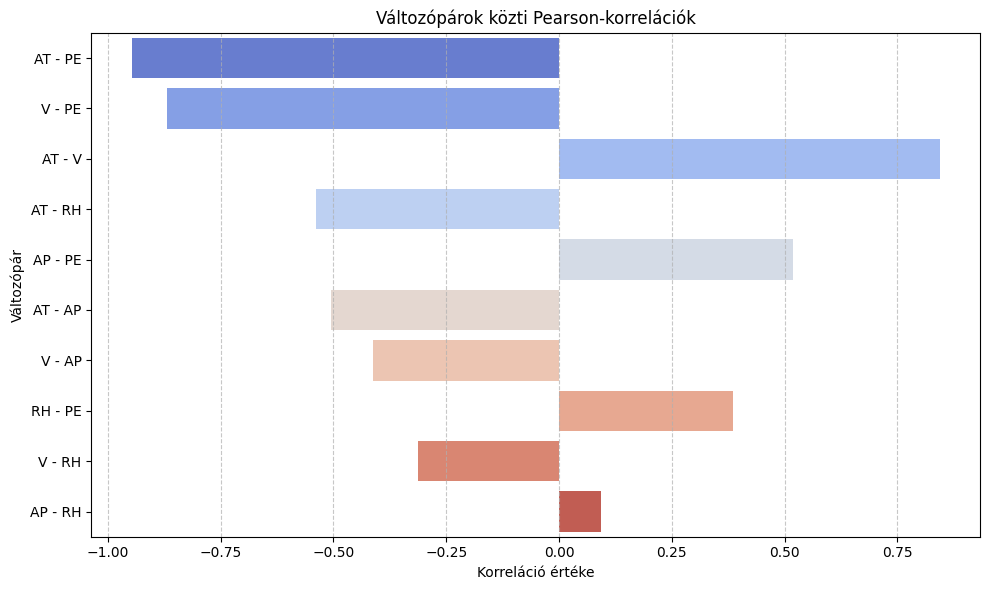

In [15]:
# Egyedi párok kigyűjtése (önmagát és ismétlődéseket kivéve)
corr_pairs = (
    corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))  # csak felső háromszög
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Változó 1', 'Változó 2', 'Korreláció']

# Abszolút érték szerint rendezés (ha erősség a lényeg)
corr_pairs['abs_corr'] = corr_pairs['Korreláció'].abs()
corr_pairs_sorted = corr_pairs.sort_values(by='abs_corr', ascending=False)

# Y tengely felirat: változópárok összefűzve
corr_pairs_sorted['Pár'] = corr_pairs_sorted['Változó 1'] + ' - ' + corr_pairs_sorted['Változó 2']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=corr_pairs_sorted,
    x='Korreláció',
    y='Pár',
    hue='Pár',              # <-- ez teszi lehetővé a színezést
    palette='coolwarm',
    dodge=False,
    legend=False            # <-- hogy ne jelenjen meg a 100 soros legenda
)
plt.title('Változópárok közti Pearson-korrelációk')
plt.xlabel('Korreláció értéke')
plt.ylabel('Változópár')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

A Pearson-korrelációs mátrix megerősíti azokat a lineáris összefüggéseket, amelyeket a pairplot alapján vizuálisan is láttam. A korrelációs értékek páronkénti rendezése és a változópárok közötti korrelációs diagram segítségével egyértelműen látható, hogy a környezeti hőmérséklet (AT) és az elektromos teljesítmény (PE), a vákuum (V) és PE, valamint az AT és V változók között a legerősebb lineáris kapcsolat áll fenn. Ez magyarázza, hogy ezek a párosok voltak a legfeltűnőbbek a pairplot ábrákon is.

Érdekességként megfigyelhető, hogy bár a környezeti hőmérséklet (AT) és a relatív páratartalom (RH) közötti kapcsolat a pairplot alapján kevésbé volt szembetűnő, a korrelációs mátrix alapján egy gyenge, de mégis kimutatható összefüggés áll fenn köztük.

## Modell készítése

In [16]:
from sklearn.model_selection import train_test_split

# 1. Feature-target szétválasztás
X = df_train.drop(columns='PE')
y = df_train['PE']

# 2. Először train-test split (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Ezután a train_val részt bontjuk tovább: 75% train, 25% validáció (vagyis 60-20-20 összesen)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

### Scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# X skálázása
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)


### Modellek és hiperparaméter-beállítások

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, RANSACRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
            'positive': [False, True]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'fit_intercept': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
            'fit_intercept': [True, False],
            'selection': ['cyclic', 'random']
        }
    },
    'ElasticNet': {
        'model': ElasticNet(max_iter=10000),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'fit_intercept': [True, False],
            'selection': ['cyclic', 'random']
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['rbf', 'poly'],
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.5, 1.0]
        }
    },
    'RANSAC': {
        'model': RANSACRegressor(),
        'params': {
            'min_samples': [0.5, 0.75],
            'residual_threshold': [5.0, 10.0]
        }
    },
    'Huber': {
        'model': HuberRegressor(),
        'params': {
            'epsilon': [1.35, 1.5, 1.75],
            'alpha': [0.0001, 0.001, 0.01]
        }
    },
    'Bagging': {
        'model': BaggingRegressor(estimator=DecisionTreeRegressor()),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_samples': [0.5, 1.0],
            'max_features': [0.5, 1.0]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }
}


### Modellválasztás PCA-vel és feature subset kereséssel GridSearchCV segítségével

In [19]:
import itertools
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

cv = KFold(n_splits=5, shuffle=True, random_state=42)

features = X_train.columns.tolist()

# -------------------- PCA alapú keresés --------------------
results_pca = []
best_score_pca = -np.inf

for name, config in models.items():
    print(f"🔍 PCA - Futtatás: {name}")
    
    pipe = Pipeline([
        ('pca', PCA()),
        ('model', config['model'])
    ])
    
    param_grid = {
        'pca__n_components': [None, 2, 3, 4],
        **{f'model__{k}': v for k, v in config['params'].items()}
    }
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=make_scorer(r2_score),
        cv=cv,
        n_jobs=-1
    )
    
    grid.fit(X_train_scaled, y_train)
    y_val_pred = grid.best_estimator_.predict(X_val_scaled)

    r2_val = r2_score(y_val, y_val_pred)
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_val_pred)

    results_pca.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'CV R²': round(grid.best_score_, 4),
        'Validation R²': round(r2_val, 4),
        'Validation RMSE': round(rmse_val, 4),
        'Validation MAE': round(mae_val, 4)
    })

results_pca_df = pd.DataFrame(results_pca).sort_values(by='Validation R²', ascending=False)

# -------------------- Feature Subset keresés --------------------
results_subset = []
best_score_subset = -np.inf

for name, config in models.items():
    print(f"🔍 SUBSET - Futtatás: {name}")
    
    best_model_score = -np.inf
    best_model_result = {}

    for r in range(1, len(features) + 1):
        for combo in itertools.combinations(features, r):
            selected_features = list(combo)
            selected_indices = [features.index(f) for f in selected_features]

            pipe = Pipeline([('model', config['model'])])
            grid = GridSearchCV(
                estimator=pipe,
                param_grid={f'model__{k}': v for k, v in config['params'].items()},
                scoring=make_scorer(r2_score),
                cv=cv,
                n_jobs=-1
            )

            grid.fit(X_train_scaled[:, selected_indices], y_train)
            y_val_pred = grid.best_estimator_.predict(X_val_scaled[:, selected_indices])

            r2_val = r2_score(y_val, y_val_pred)
            mse_val = mean_squared_error(y_val, y_val_pred)
            rmse_val = np.sqrt(mse_val)
            mae_val = mean_absolute_error(y_val, y_val_pred)

            if r2_val > best_model_score:
                best_model_score = r2_val
                best_model_result = {
                    'Model': name,
                    'Best Params': grid.best_params_,
                    'CV R²': round(grid.best_score_, 4),
                    'Validation R²': round(r2_val, 4),
                    'Validation RMSE': round(rmse_val, 4),
                    'Validation MAE': round(mae_val, 4),
                    'Used Features': selected_features
                }

                if r2_val > best_score_subset:
                    best_score_subset = r2_val
                    best_model = grid.best_estimator_
                    best_name = name
                    best_params = grid.best_params_
                    best_features = selected_features

    results_subset.append(best_model_result)

results_subset_df = pd.DataFrame(results_subset).sort_values(by='Validation R²', ascending=False)


🔍 PCA - Futtatás: LinearRegression
🔍 PCA - Futtatás: Ridge
🔍 PCA - Futtatás: Lasso
🔍 PCA - Futtatás: ElasticNet
🔍 PCA - Futtatás: SVR
🔍 PCA - Futtatás: RANSAC
🔍 PCA - Futtatás: Huber
🔍 PCA - Futtatás: Bagging
🔍 PCA - Futtatás: GradientBoosting
🔍 SUBSET - Futtatás: LinearRegression
🔍 SUBSET - Futtatás: Ridge
🔍 SUBSET - Futtatás: Lasso
🔍 SUBSET - Futtatás: ElasticNet
🔍 SUBSET - Futtatás: SVR
🔍 SUBSET - Futtatás: RANSAC
🔍 SUBSET - Futtatás: Huber
🔍 SUBSET - Futtatás: Bagging
🔍 SUBSET - Futtatás: GradientBoosting


In [20]:
from IPython.display import display

print("🎯 PCA alapú modellek:")
with pd.option_context('display.max_colwidth', None):
    display(results_pca_df)

print("🔍 Feature subset alapú modellek:")
with pd.option_context('display.max_colwidth', None):
    display(results_subset_df)


🎯 PCA alapú modellek:


,Model,Best Params,CV R²,Validation R²,Validation RMSE,Validation MAE
7,Bagging,"{'model__max_features': 1.0, 'model__max_samples': 1.0, 'model__n_estimators': 100, 'pca__n_components': 4}",0.9466,0.9470,3.8636,2.8732
8,GradientBoosting,"{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100, 'pca__n_components': 4}",0.9433,0.9417,4.0525,3.1119
4,SVR,"{'model__C': 10, 'model__epsilon': 1.0, 'model__kernel': 'rbf', 'pca__n_components': None}",0.9430,0.9414,4.0634,3.1329
0,LinearRegression,"{'model__fit_intercept': True, 'model__positive': False, 'pca__n_components': None}",0.9282,0.9232,4.6513,3.7422
1,Ridge,"{'model__alpha': 1.0, 'model__fit_intercept': True, 'model__solver': 'lsqr', 'pca__n_components': None}",0.9282,0.9232,4.6511,3.7421
2,Lasso,"{'model__alpha': 0.001, 'model__fit_intercept': True, 'model__selection': 'cyclic', 'pca__n_components': None}",0.9282,0.9232,4.6511,3.7421
3,ElasticNet,"{'model__alpha': 0.001, 'model__fit_intercept': True, 'model__l1_ratio': 0.9, 'model__selection': 'cyclic', 'pca__n_components': None}",0.9282,0.9232,4.6511,3.7421
5,RANSAC,"{'model__min_samples': 0.5, 'model__residual_threshold': 10.0, 'pca__n_components': None}",0.9282,0.9228,4.6642,3.7491
6,Huber,"{'model__alpha': 0.01, 'model__epsilon': 1.75, 'pca__n_components': None}",0.9282,0.9228,4.6637,3.7479


🔍 Feature subset alapú modellek:


,Model,Best Params,CV R²,Validation R²,Validation RMSE,Validation MAE,Used Features
8,GradientBoosting,"{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}",0.9576,0.9614,3.2998,2.4763,"[AT, V, AP, RH]"
7,Bagging,"{'model__max_features': 1.0, 'model__max_samples': 1.0, 'model__n_estimators': 100}",0.9533,0.9562,3.5141,2.5803,"[AT, V, AP, RH]"
4,SVR,"{'model__C': 10, 'model__epsilon': 1.0, 'model__kernel': 'rbf'}",0.9430,0.9414,4.0634,3.1329,"[AT, V, AP, RH]"
0,LinearRegression,"{'model__fit_intercept': True, 'model__positive': False}",0.9282,0.9232,4.6513,3.7422,"[AT, V, AP, RH]"
1,Ridge,"{'model__alpha': 1.0, 'model__fit_intercept': True, 'model__solver': 'lsqr'}",0.9282,0.9232,4.6511,3.7421,"[AT, V, AP, RH]"
2,Lasso,"{'model__alpha': 0.001, 'model__fit_intercept': True, 'model__selection': 'random'}",0.9282,0.9232,4.6512,3.7421,"[AT, V, AP, RH]"
3,ElasticNet,"{'model__alpha': 0.001, 'model__fit_intercept': True, 'model__l1_ratio': 0.9, 'model__selection': 'random'}",0.9282,0.9232,4.6511,3.7421,"[AT, V, AP, RH]"
6,Huber,"{'model__alpha': 0.01, 'model__epsilon': 1.75}",0.9282,0.9228,4.6637,3.7479,"[AT, V, AP, RH]"
5,RANSAC,"{'model__min_samples': 0.75, 'model__residual_threshold': 10.0}",0.9281,0.9227,4.6670,3.7502,"[AT, V, AP, RH]"


In [ ]:
# -------------------- PCA legjobb modell értékelése teszten --------------------
X_trainval_full = np.vstack([X_train_scaled, X_val_scaled])
y_trainval_full = np.concatenate([y_train, y_val])

best_model_pca = results_pca_df.iloc[0]
pca_model_name = best_model_pca['Model']
pca_model_params = best_model_pca['Best Params']

# Rekonstruáljuk újra a pipe-ot a PCA alapján
pipe_pca_final = Pipeline([
    ('pca', PCA(n_components=pca_model_params.get('pca__n_components'))),
    ('model', models[pca_model_name]['model'].set_params(
        **{k.replace('model__', ''): v for k, v in pca_model_params.items() if k.startswith('model__')}
    ))
])

pipe_pca_final.fit(X_trainval_full, y_trainval_full)
y_test_pred_pca = pipe_pca_final.predict(X_test_scaled)

r2_test_pca = r2_score(y_test, y_test_pred_pca)
rmse_test_pca = np.sqrt(mean_squared_error(y_test, y_test_pred_pca))
mae_test_pca = mean_absolute_error(y_test, y_test_pred_pca)

print(f"\n🧪 Teszt eredmények - PCA alapú legjobb modell ({pca_model_name}):")
print(f"Test R²: {r2_test_pca:.4f}")
print(f"Test RMSE: {rmse_test_pca:.4f}")
print(f"Test MAE: {mae_test_pca:.4f}")


# -------------------- Feature Subset legjobb modell értékelése teszten --------------------
best_model_subset = results_subset_df.iloc[0]
subset_model_name = best_model_subset['Model']
subset_model_params = best_model_subset['Best Params']
subset_features = best_model_subset['Used Features']
subset_indices = [features.index(f) for f in subset_features]

X_trainval_subset = X_trainval_full[:, subset_indices]
X_test_subset = X_test_scaled[:, subset_indices]

pipe_subset_final = Pipeline([
    ('model', models[subset_model_name]['model'].set_params(
        **{k.replace('model__', ''): v for k, v in subset_model_params.items() if k.startswith('model__')}
    ))
])

pipe_subset_final.fit(X_trainval_subset, y_trainval_full)
y_test_pred_subset = pipe_subset_final.predict(X_test_subset)

r2_test_subset = r2_score(y_test, y_test_pred_subset)
rmse_test_subset = np.sqrt(mean_squared_error(y_test, y_test_pred_subset))
mae_test_subset = mean_absolute_error(y_test, y_test_pred_subset)

print(f"\n🧪 Teszt eredmények - Feature Subset alapú legjobb modell ({subset_model_name}):")
print(f"Test R²: {r2_test_subset:.4f}")
print(f"Test RMSE: {rmse_test_subset:.4f}")
print(f"Test MAE: {mae_test_subset:.4f}")


# -------------------- Globális győztes kiválasztása --------------------
if r2_test_pca > r2_test_subset:
    print(f"\n🏆 Végső nyertes modell: PCA alapú {pca_model_name} (Test R²: {r2_test_pca:.4f})")
    final_model = pipe_pca_final
    final_model_name = pca_model_name
else:
    print(f"\n🏆 Végső nyertes modell: Feature Subset alapú {subset_model_name} (Test R²: {r2_test_subset:.4f})")
    final_model = pipe_subset_final
    final_model_name = subset_model_name


🧪 Teszt eredmények - PCA alapú legjobb modell (Bagging):
Test R²: 0.9472
Test RMSE: 3.8891
Test MAE: 2.7780

🧪 Teszt eredmények - Feature Subset alapú legjobb modell (GradientBoosting):
Test R²: 0.9605
Test RMSE: 3.3634
Test MAE: 2.3839

🏆 Végső nyertes modell: Feature Subset alapú GradientBoosting (Test R²: 0.9605)


A fentebb látható folyamatok leírása:

Adatelőkészítés  
Első lépésként szétválasztottam a bemeneti változókat (X) és a célváltozót (y), majd az adatokat három részre bontottam:  
60% tanító adathalmaz (train),  
20% validációs adathalmaz (val),  
20% teszt adathalmaz (belső test),  
hogy elkülönítsem az adatokat tanításra, hangolásra és teljesítményértékelésre.  

Scaling alkalmazása  
Ezután a bemeneti változókat (X) standardizáltam StandardScaler segítségével, hogy az egyes változók azonos skálán mozogjanak, ami sok modell esetében javítja a teljesítményt.

Modellek és paraméterrács definiálása  
A vizsgálathoz többféle regressziós modellt választottam. Ezek közül néhányat a csatolt cikk is használt, a többit pedig azért tettem bele, mert a scikit-learn könyvtárban elérhetőek, jól működnek regressziós problémákra, és így jobban össze tudtam hasonlítani őket.  
A cikkben is szereplő modellek:
Bagging Regressor – a cikkben Bagging REP Tree néven szerepelt, én döntési fával kombinálva használtam.  
Gradient Boosting Regressor – ez is szerepelt a tanulmányban, és jól ismert, hatékony modell.
További, általánosan használt modellek:  
Linear Regression, Ridge, Lasso, ElasticNet – ezek a klasszikus lineáris modellek, amikkel jól lehet alapként dolgozni.
SVR (Support Vector Regressor) – ez a modell jól tud kezelni nemlineáris kapcsolatokat is.
RANSAC és Huber Regressor – ezek robusztus modellek, jól működnek akkor is, ha vannak outlierek az adatokban.  
Minden modellhez meghatároztam egy paraméterrácsot, vagyis egy listát, hogy milyen beállításokat próbáljon ki a gép. A modelleket ezek alapján automatikusan hangoltam a GridSearchCV segítségével. Így mindegyik modell a saját legjobb beállításával tudott versenyezni a többivel, és tisztán össze tudtam hasonlítani a teljesítményüket.

Modellek tanítása és optimalizálása kétféle módszerrel
1. PCA-alapú keresés
Létrehoztam egy pipelinet, amely először PCA-val csökkentette a bemeneti dimenziót, majd az adott modellt tanította. GridSearchCV segítségével kerestem meg a legjobb modellparamétereket és a legjobb PCA-komponensszámot. A validációs eredmények alapján kiválasztottam a legjobb teljesítményű PCA-s modellt.
2. Exhaustive Feature Subset keresés
Itt nem PCA-t alkalmaztam, hanem végigpróbáltam az összes lehetséges feature-kombinációt (összes subsetet). Minden modellnél kiválasztottam azt a feature-részhalmazt, amellyel a legjobb validációs R² értéket érte el. Így külön minden modellre megtaláltam a számára legjobb feature-készletet.

A két módszer eredményeinek összehasonlítása  
A két módszerrel megtalált legjobb modellt (PCA-s és Feature Subsetes) újratanítottam a teljes train+val adathalmazon, majd kiértékeltem őket a belső tesztkészleten. Ez alapján kiválasztottam a végső győztes modellt – azt, amelyik a legmagasabb R² értéket adta a belső teszten.

Végső modell kiértékelése külső (real) tesztkészleten  
A real tesztadatok RH oszlopára ugyanúgy alkalmaztam a Yeo–Johnson transzformációt, mint a train esetén, majd ugyanazzal a skálázóval transformáltam az adatokat. Ezután a kiválasztott végső modellel (pipeline formában) predikciót végeztem, és kiszámoltam az R², RMSE és MAE értékeket.

## Modellértékelés

### Elkészült modell validálás a Test.xlsx adatai alapján

In [27]:
from scipy.stats import yeojohnson

# Alkalmazzuk a Yeo–Johnson transzformációt a df_test 'RH' oszlopára,
# ugyanolyan módon, ahogy a train adatoknál alkalmaztad.
df_test['RH'] = pd.Series(yeojohnson(df_test['RH'])[0], index=df_test.index)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# A test adatok feature és target kiválasztása
X_test_real = df_test.drop(columns='PE')
y_test_real = df_test['PE']

# Skálázás ugyanazzal a scaler_X-el, amit a train során fit-eltél
X_test_real_scaled = scaler_X.transform(X_test_real)

# Ha a final_model egy feature subset alapú modell, akkor szűrjük az oszlopokat,
# különben a teljes skálázott adathalmazt használjuk.
try:
    X_test_input = X_test_real_scaled[:, subset_indices]
except NameError:
    X_test_input = X_test_real_scaled

# A final model predikciója a real test adatokon
y_pred_real = final_model.predict(X_test_input)

# Teszt metrikák számítása
r2_real = r2_score(y_test_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae_real = mean_absolute_error(y_test_real, y_pred_real)

print(f"Test R²:   {r2_real:.4f}")
print(f"Test RMSE: {rmse_real:.4f}")
print(f"Test MAE:  {mae_real:.4f}")


Test R²:   0.9617
Test RMSE: 3.2435
Test MAE:  2.4683


A végső modell kiértékelését a külön kapott Test.xlsx fájl alapján is elvégeztem. A predikció során ugyanazokat az előfeldolgozási lépéseket alkalmaztam, mint a tanító adaton (pl. Yeo–Johnson transzformáció, skálázás). Az eredmények alapján a modell nagyon jól teljesített az ismeretlen adatokon is:
  
R²: 0.9617  
RMSE: 3.2435  
MAE: 2.4683  
  
Ez azt mutatja, hogy a modell jól általánosít, és megbízhatóan becsüli meg az elektromos teljesítményt a tesztkészleten is.  

### Predikált vs. Valós értékek – Belső és Külső Teszt összehasonlítása

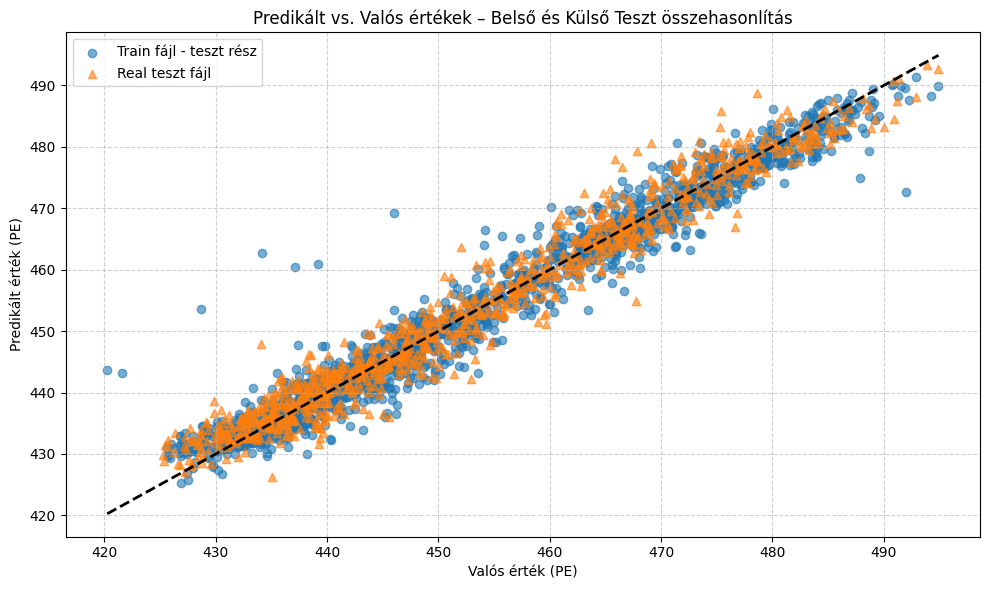

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Belső (train fájlból származó) teszt adatok
y_pred_internal = final_model.predict(X_test_scaled)
plt.scatter(y_test, y_pred_internal, alpha=0.6, label='Train fájl - teszt rész', marker='o')

# Külső (real fájlból származó) teszt adatok
y_pred_real = final_model.predict(X_test_real_scaled)
plt.scatter(y_test_real, y_pred_real, alpha=0.6, label='Real teszt fájl', marker='^')

# Átló – ideális predikció
# Ez a rész felelős azért, hogy a Train.xlsx részből leválasztott test rész
# együtt tudjon szerepelni a grafikonon a Test.xlsx részben levő teljes (teszt) adattal a predikció után
min_val = min(y_test.min(), y_test_real.min())
max_val = max(y_test.max(), y_test_real.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('Valós érték (PE)')
plt.ylabel('Predikált érték (PE)')
plt.title('Predikált vs. Valós értékek – Belső és Külső Teszt összehasonlítás')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


A fenti ábrán a modell előrejelzéseit hasonlítottam össze a valós elektromos teljesítmény (PE) értékekkel kétféle tesztkészleten:
a belső tesztkészlet a tanító fájlból lett leválasztva, a külső (real) tesztkészlet pedig egy teljesen külön fájlból származik, amit a modell korábban nem látott.
Mindkét esetben jól látható, hogy az előrejelzések közel vannak az ideális, szaggatott átlóhoz, ami azt jelenti, hogy a modell pontosan tudott becsülni. Érdekesség, hogy a külső tesztkészleten még jobban is teljesített: ott az R² érték 0.9617, míg a belső teszten "csak" 0.9605 volt.
Ez arra utal, hogy a külső adatok nem különböznek jelentősen a tanításhoz használt mintáktól, vagy ha van is eltérés, azt a modell jól tudta kezelni.

Lehetséges okok a külső teszten mért jobb eredményre:
A real tesztkészlet tisztább vagy kevésbé zajos, mint a belső.
Az inputváltozók (például RH vagy AT) jobban illeszkedtek a modell által megtanult tartományhoz.
A Yeo–Johnson transzformáció egységes alkalmazása után az adatok feldolgozása is kiegyensúlyozottabb lett.

Összességében a modell nemcsak a tanulási adatokra emlékezik, hanem tényleges mintázatokat tanult meg, amiket ismeretlen adatokon is jól tud alkalmazni.

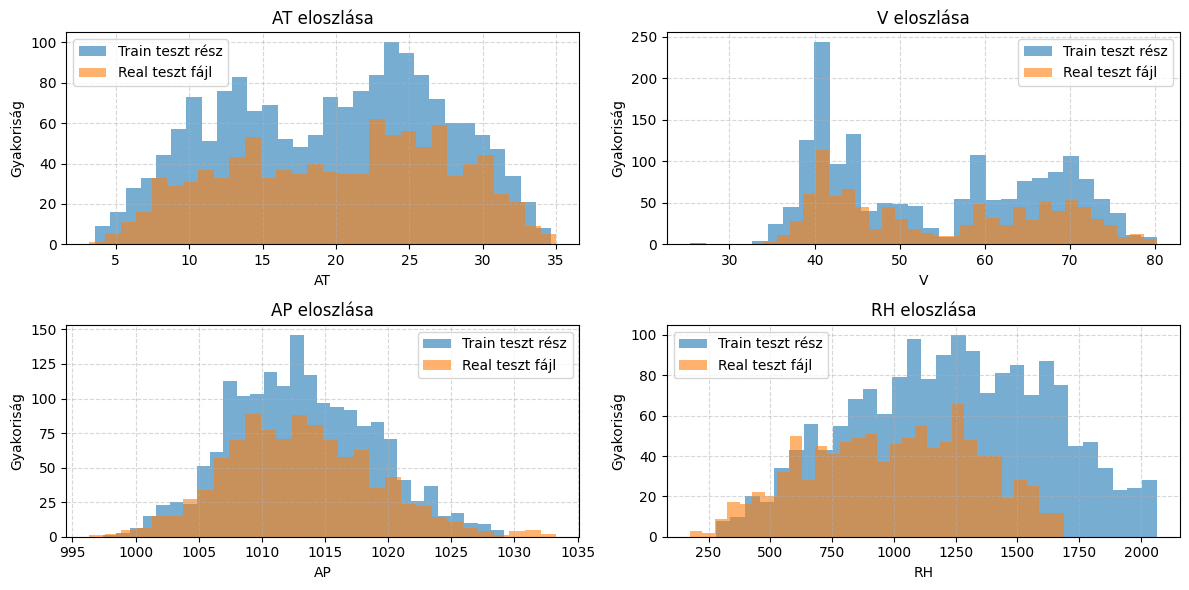

In [29]:
import matplotlib.pyplot as plt

# Trainből származó test rész (X_test_scaled eredeti, nem skálázott változatai kellenek)
X_test_internal = pd.DataFrame(scaler_X.inverse_transform(X_test_scaled), columns=X_test.columns)
X_test_real_unscaled = pd.DataFrame(scaler_X.inverse_transform(X_test_real_scaled), columns=X_test_real.columns)

# Feature eloszlások összehasonlítása
features = X_test.columns
n_cols = 2
n_rows = (len(features) + 1) // n_cols

plt.figure(figsize=(12, n_rows * 3))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(X_test_internal[feature], bins=30, alpha=0.6, label='Train teszt rész')
    plt.hist(X_test_real_unscaled[feature], bins=30, alpha=0.6, label='Real teszt fájl')
    plt.title(f'{feature} eloszlása')
    plt.xlabel(feature)
    plt.ylabel('Gyakoriság')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Ha a real tesztfájl kevesebb zajt vagy kevesebb szélsőséges értéket tartalmaz, akkor a modellnek könnyebb pontosan jósolni. Ez magyarázza, hogy miért lehet ott magasabb az R² érték. A hisztogramok alapján a real tesztadatok eloszlása nagyon hasonló a tanító adatokéhoz, sőt néhol még „egyszerűbb” is lehet a modell szempontjából. Emiatt lehetséges, hogy a modell ezen a teszten még jobban is teljesít, mint a belső tesztrészen.

## Eredmények összegzése és összehasonlítása

Eredmények összegzése és összehasonlítás a cikkel:  
A saját modell kiválasztása és finomhangolása után a végső modell teljesítményét egy különálló, külső tesztfájlon értékeltem. A predikciós pontosságot az alábbi mutatók alapján vizsgáltam:

Test R²: 0.9617  
Test RMSE: 3.2435  
Test MAE: 2.4683  

A cikkben bemutatott legjobb modell (Bagging REP Tree – BREP) a teljes feature készlettel az alábbi eredményeket érte el:  

RMSE: 3.787  
MAE: 2.818  

Az összehasonlítás alapján jól látható, hogy a saját modell mindkét hibaértékben (RMSE és MAE) alacsonyabb hibát produkált, tehát pontosabban tudta előre jelezni az elektromos teljesítményt. Emellett a saját modell R² értéke is kiemelkedően magas, ami azt jelenti, hogy a modell a bemeneti változók alapján nagyon jól tudta megmagyarázni a célváltozó alakulását.

Ez alapján elmondható, hogy a kidolgozott modell nemcsak stabil és jól általánosító, hanem a cikk legjobb eredményeinél is pontosabb teljesítményt tudott nyújtani a külső tesztkészleten. Az előfeldolgozási lépések (pl. Yeo–Johnson transzformáció), a változók kiválasztása és a modellek alapos hangolása mind hozzájárulhattak ehhez az eredményhez.